In [1]:
%matplotlib inline

import time
import datetime

import pandas as pd
import matplotlib.pylab as plt
import numpy as np

from scipy.optimize import curve_fit
from jupyterthemes import jtplot

jtplot.style(theme='onedork')

In [2]:
# Data from:
# https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series

url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

In [3]:
df = pd.read_csv(url, index_col=[0,1])
df

Lat     Long  1/22/20  1/23/20  \
Province/State           Country/Region                                       
NaN                      Afghanistan     33.0000  65.0000        0        0   
                         Albania         41.1533  20.1683        0        0   
                         Algeria         28.0339   1.6596        0        0   
                         Andorra         42.5063   1.5218        0        0   
                         Angola         -11.2027  17.8739        0        0   
...                                          ...      ...      ...      ...   
Anguilla                 United Kingdom  18.2206 -63.0686        0        0   
British Virgin Islands   United Kingdom  18.4207 -64.6400        0        0   
Turks and Caicos Islands United Kingdom  21.6940 -71.7979        0        0   
NaN                      MS Zaandam       0.0000   0.0000        0        0   
                         Botswana       -22.3285  24.6849        0        0   

                                         1/24/20  1/25/20  1/26/20  1/27/20  \
Province/State           Country/Region                                       
NaN                      Afghanistan           0        0        0        0   
                         Albania               0        0        0        0   
                         Algeria               0        0        0        0   
                         Andorra               0        0        0        0   
                         Angola                0        0        0        0   
...                                          ...      ...      ...      ...   
Anguilla                 United Kingdom        0        0        0        0   
British Virgin Islands   United Kingdom        0        0        0        0   
Turks and Caicos Islands United Kingdom        0        0        0        0   
NaN                      MS Zaandam            0        0        0        0   
                         Botswana              0        0        0        0   

                                         1/28/20  1/29/20  ...  3/21/20  \
Province/State           Country/Region                    ...            
NaN                      Afghanistan           0        0  ...        0   
                         Albania               0        0  ...        2   
                         Algeria               0        0  ...       15   
                         Andorra               0        0  ...        0   
                         Angola                0        0  ...        0   
...                                          ...      ...  ...      ...   
Anguilla                 United Kingdom        0        0  ...        0   
British Virgin Islands   United Kingdom        0        0  ...        0   
Turks and Caicos Islands United Kingdom        0        0  ...        0   
NaN                      MS Zaandam            0        0  ...        0   
                         Botswana              0        0  ...        0   

                                         3/22/20  3/23/20  3/24/20  3/25/20  \
Province/State           Country/Region                                       
NaN                      Afghanistan           1        1        1        2   
                         Albania               2        4        5        5   
                         Algeria              17       17       19       21   
                         Andorra               1        1        1        1   
                         Angola                0        0        0        0   
...                                          ...      ...      ...      ...   
Anguilla                 United Kingdom        0        0        0        0   
British Virgin Islands   United Kingdom        0        0        0        0   
Turks and Caicos Islands United Kingdom        0        0        0        0   
NaN                      MS Zaandam            0        0        0        0   
                         Botswana              0        0        

In [4]:
df2 = df.drop(['Lat', 'Long'], 1).groupby(level=1).sum().T
df2.index = pd.to_datetime(df2.index)
last_date = df2.index[-1]

df2

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Zambia,Zimbabwe
2020-01-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-26,4,6,25,3,0,0,9,1,13,49,...,5,2,580,0,0,0,0,1,0,1
2020-03-27,4,8,26,3,0,0,13,1,13,58,...,5,2,761,0,1,1,0,1,0,1
2020-03-28,4,10,29,3,0,0,18,1,14,68,...,9,2,1021,0,2,2,0,1,0,1
2020-03-29,4,10,31,6,2,0,19,3,16,86,...,10,3,1231,1,2,2,0,1,0,1


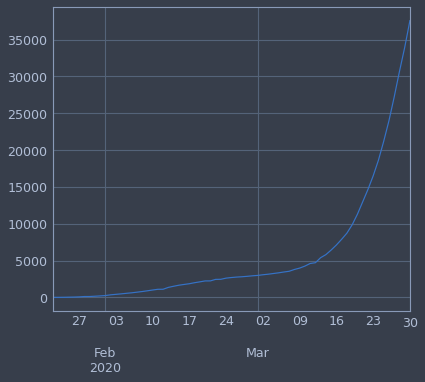

In [5]:
df2.T.sum().plot()

In [6]:
len(df2.columns)

178

In [7]:
df_exchina = df2.drop('China', 1)
df_exchina = df_exchina[df_exchina.T.sum() > 1]
len(df_exchina.columns)

177

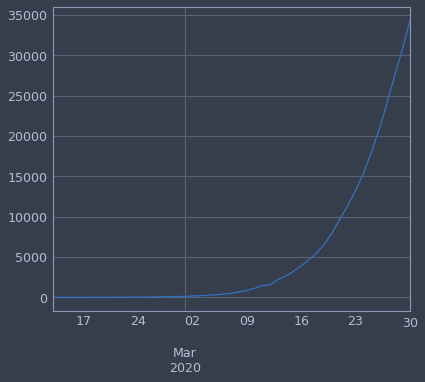

In [8]:
df_exchina.T.sum().plot()

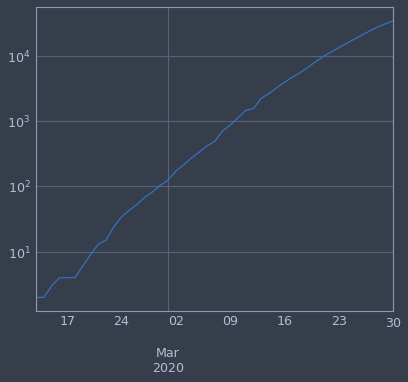

In [9]:
df_exchina.T.sum().plot(logy = True)

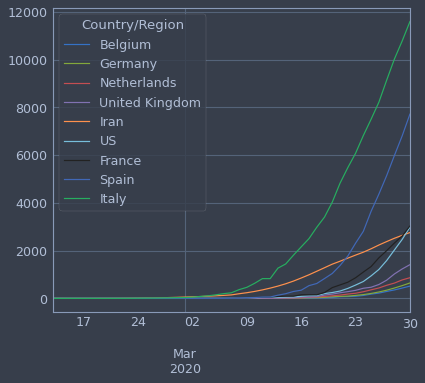

In [10]:
df_exchina.T.sort_values(by=last_date).tail(9).T.plot()

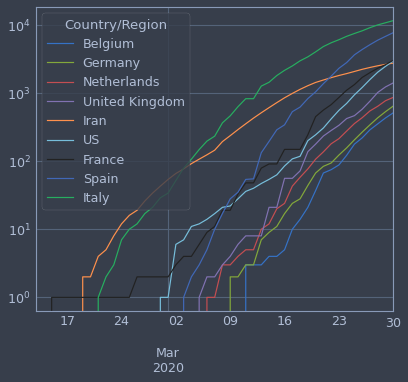

In [11]:
df_exchina.T.sort_values(by=last_date).tail(9).T.plot(logy = True)

In [12]:
df_exchina.T.sort_values(by=last_date).tail(9).T.diff().tail()

Country/Region,Belgium,Germany,Netherlands,United Kingdom,Iran,US,France,Spain,Italy
2020-03-26,42.0,61.0,78.0,114.0,157.0,267.0,365.0,718.0,712.0
2020-03-27,69.0,75.0,112.0,181.0,144.0,372.0,299.0,773.0,919.0
2020-03-28,64.0,91.0,93.0,260.0,139.0,445.0,320.0,844.0,889.0
2020-03-29,78.0,100.0,132.0,210.0,123.0,441.0,294.0,821.0,756.0
2020-03-30,82.0,112.0,93.0,180.0,117.0,511.0,419.0,913.0,812.0


In [13]:
def sigmoid(x, sat, td, velo):
    x = np.float64(x)
    
    td *= 1e10
    td *= 1e9
    
    real_sat = 1e5 * sat
    x = x - td
    x /= 1e14
    return real_sat / (1 + np.exp(-x * velo))

x = df_exchina.index
sat = 30000 / 1e5
td = time.time() / 1e10
velo = .1

In [14]:
popt, pcov = curve_fit(f = sigmoid, 
                       xdata = df_exchina.index, 
                       ydata = df_exchina.T.sum(), 
                       p0 = (sat, td, velo)
                      )

In [15]:
y_fit = sigmoid(x, *list(popt))

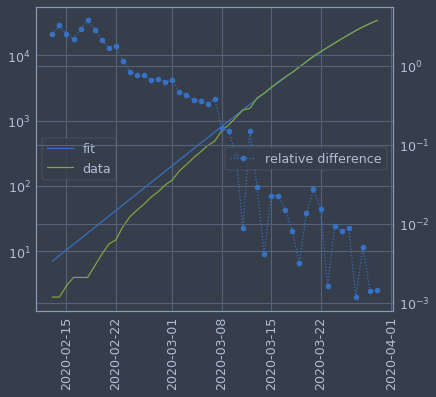

In [16]:
fig, ax1 = plt.subplots()
plt.xticks(rotation=90)


ax1.semilogy(x, y_fit, label="fit")
ax1.semilogy(x, df_exchina.T.sum(), label="data")

ax2 = ax1.twinx()
ax2.semilogy(x, abs(y_fit - df_exchina.T.sum())/df_exchina.T.sum(), "o:", label="relative difference")
# ax1.legend(loc="lower left")
# ax2.legend(loc="center left")
ax1.legend(loc="center left")
ax2.legend(loc="center right")

In [17]:
th = datetime.datetime.fromtimestamp(popt[1] * 1e10)

In [18]:
f'The total number of Deaths outside China due to Covid-19 will be {int(popt[0] * 1e5)}. Half of those will be reached at {th.strftime("%Y-%B-%d %H:%M")}'

'The total number of Deaths outside China due to Covid-19 will be 72776. Half of those will be reached at 2020-March-30 16:25'

In [19]:
tstart = min(df_exchina.index)
tend = tstart + (th - tstart) * 2

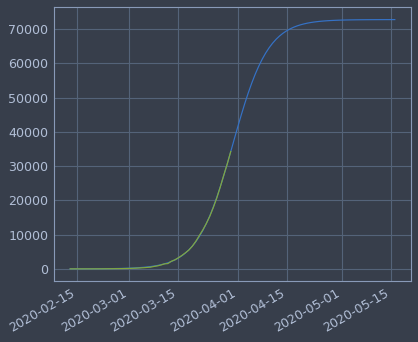

In [20]:
x_extra = np.arange(tstart, tend, datetime.timedelta(days=1)).astype('datetime64[ns]')
y_extra = sigmoid(x_extra, *list(popt))

plt.plot(x_extra, y_extra)
df_exchina.T.sum().plot()
plt.show()

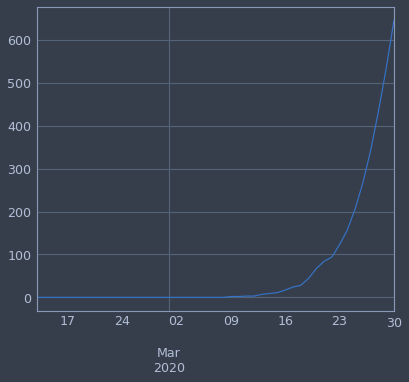

In [21]:
df_exchina["Germany"].T.plot(logy=False)

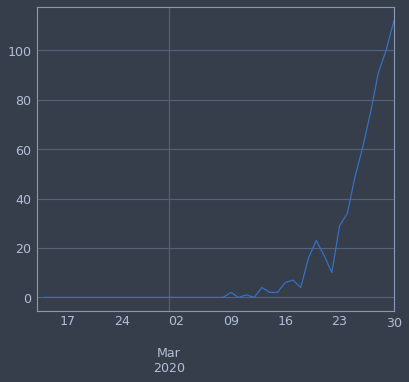

In [64]:
df_exchina["Germany"].T.diff().plot()

In [22]:
df_exchina.T.sum().diff().tail()

2020-03-26    2783.0
2020-03-27    3223.0
2020-03-28    3451.0
2020-03-29    3268.0
2020-03-30    3653.0
dtype: float64

In [23]:
x = []
y_var = []
y = []
h = []

for e in df_exchina.index[30:]:
    df_temp = df_exchina[:e]
    
    popt, pcov = curve_fit(f = sigmoid, 
                       xdata = df_temp.index, 
                       ydata = df_temp.T.sum(), 
                       p0 = (sat, td, velo)
                      )
    
    x.append(e + datetime.timedelta(days=2))
    y_var.append(np.diag(pcov)[1] * 1e10)
    y.append(datetime.datetime.fromtimestamp(popt[1] * 1e10))
    h.append(int(popt[0] * 1e5))
    

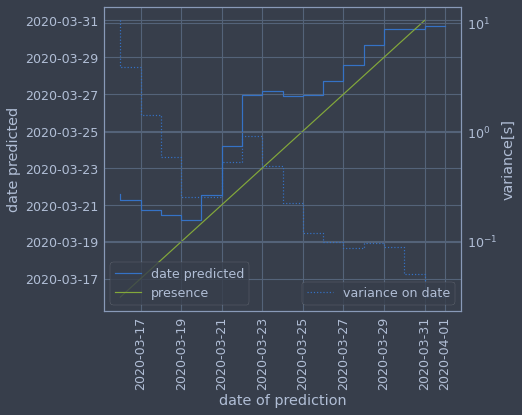

In [24]:
fig, ax1 = plt.subplots()
plt.xticks(rotation=90)
plt.xlabel("date of prediction")

plt.ylabel("date predicted")

ax1.plot(x, y, label='date predicted', drawstyle='steps')
ax1.plot(x[:-1], x[:-1], label='presence')


ax2 = ax1.twinx()
ax2.semilogy(x, y_var, ":", label='variance on date', drawstyle='steps')
plt.ylabel("variance[s]")

ax1.legend(loc="lower left")
ax2.legend(loc="lower right")

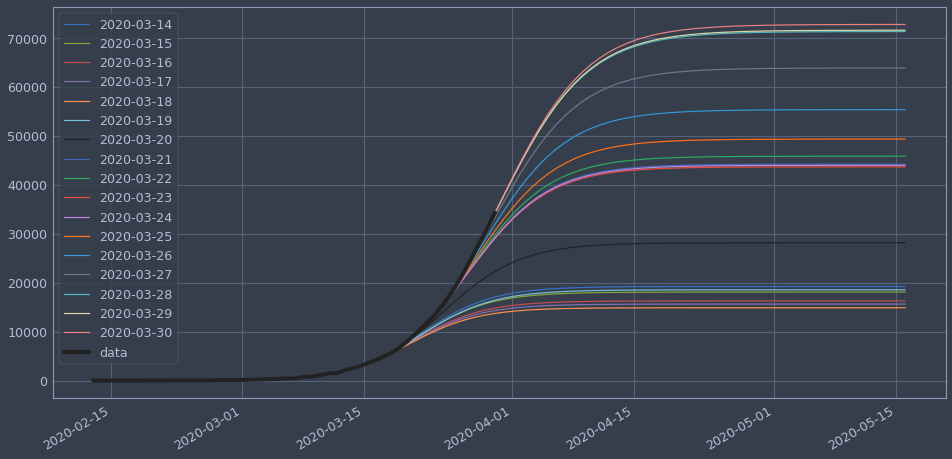

In [59]:
for e in df_exchina.index[30:]:
    df_temp = df_exchina[:e]
    
    popt, pcov = curve_fit(f = sigmoid, 
                       xdata = df_temp.index, 
                       ydata = df_temp.T.sum(), 
                       p0 = (sat, td, velo)
                      )
    y_extra = sigmoid(x_extra, *list(popt))

    plt.plot(x_extra, y_extra, label=e.strftime("%Y-%m-%d"))
df_exchina.T.sum().plot(linewidth=4, style="k", label="data", figsize=(16,8))
plt.legend(loc="upper left")
plt.show()
    